# Machine Learning on Text Classification

## Table of Contents:        
[(I) Machine Learning & Text Classification](#4-bullet)
* [(I.a) ML Questions and motivations](#41-bullet)
* [(I.b) Identifying Keywords](#42-bullet)
* [(I.c) ML model testing & comparisons](#43-bullet)
* [(I.a) Conclusions](#44-bullet)





# I. Text Classification <a class="anchor" id="4-bullet"></a>

20 years ago, text classification would have been cumbersome for experts and a harrowing feat for the everyday person (machine learning and neural nets existed at that time, but the study was very much in it's infancy). With today's storage capabilities and computing power, it can be done at home!

Text classification is a very interesting topic related to ML for me because its a process of getting quantifiable conclusions from non-numerical data. It is also a great introduction into the depth of machine learning and what sort of methods for analysis are out there.

This article is comprised of these sections:
1. creating the hypothesis
2. data creation
3. exploratory analysis
4. ML models to get performance
5. evaluating the models and tuning them

## Data Creation
The following data was pulled from the [Springer API website](https://dev.springernature.com/). 


## I.A: Creating the Hypothesis <a class="anchor" id="41-bullet"></a>

Within the scientific abstracts pulled out from the API, there were various columns of descriptive information like `publisher`, `authors`, `starting page`, and others. But one column, the `keywords` column, only contained NaN values and was of no use. In this text classfication approach, there are two questions: 

**1. Can we identify key words that represent each publication (journal)?**

**2. Given the abstract, can we predict what publication its paper would be going to?**

To start off, let's read in the data set (which was pulled from the API but then downloaded into a CSV). Then take a look at the `keywords` column.

In [110]:
# let's read in the data from the csv
import pandas as pd

# full data set
full_csv = pd.read_csv("Processed_2000to2018BMC_DF_withCitations.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Printing...
``` python 
full_csv['keywords'].unique()
``` 
... the only unique values inside the keyword column would be NaN. This means that the entire column is filled with NaN values.

For our analysis here, we'll only be using two columns (`abstract` and `publicationName`). 

<br/>

Now that we know there are no values in the `keywords` column, can we identify proper key words for each publication, given the journal?

This question is analogous to setting labels for a bunch of movies on IMDB, where the question would be, "Given a bunch of movies that are comedy, horror, and drama, can we created labels to help classify them? (Maybe if we wanted to search for some type of movie?)"

One potential application of our question (of finding the keywords for different categories of abstracts, i.e. what are keywords of Family Practice abstracts vs. Biology abstracts) is to make it easier for a layman to search through scientific papers. If she would want to learn more about the effects of `smoking` or `physical health`, she could simply search these words up and papers within Public Health should show up.

**Note:**
We'll be refining the question one step further in the next section. For the remainder of this article, "publication" and "journal" will be used interchangably.

## I.B: Identifying Keywords <a class="anchor" id="42-bullet"></a>
The first question is, "**Can we identify key words that represent each publication (journal)?**"

This question isn't too feasible for us to answer with this data set. We'll have to refine it further to get a better hypothesis. See the exploratory analysis as follows...

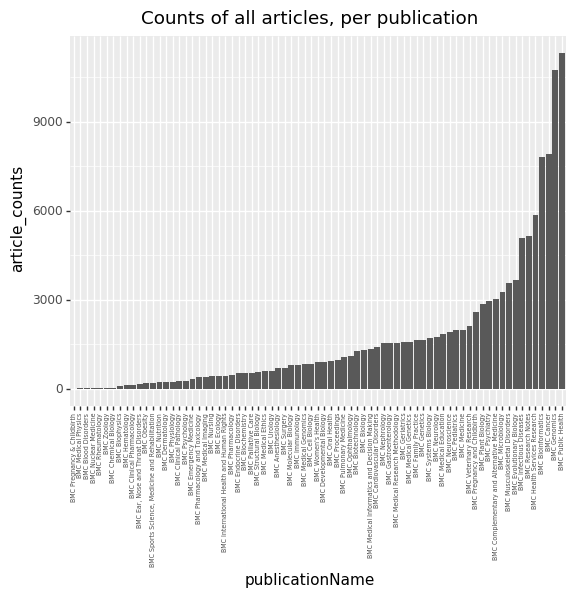

<ggplot: (141075548101)>

In [58]:
# y-val is going to be publicationName and x-vals is going to be abstract txt
# import ggplot so that we can do some basic graphs

import plotnine as p9
from pandas.api.types import CategoricalDtype
from plotnine import ggplot
y = full_csv['publicationName'] # y values; now, we're still missing x-column
pub_counts = full_csv.groupby('publicationName').size().sort_values().reset_index()
pub_counts = pub_counts.rename(columns={0:'counts'})

p9.ggplot(pub_counts)\
+ p9.aes(x='publicationName',y='counts')\
+ p9.geom_bar(stat='identity')\
+ p9.theme(axis_text_x=p9.element_text(rotation=90, size=4.5))\
+ p9.scale_x_discrete(limits=pub_counts['publicationName'])\
+ p9.labels.ggtitle("Counts of all abstracts, per publication")\
+ p9.labels.ylab("article_counts")

In [92]:
pub_counts.describe()

,counts
count,75.00000
mean,1658.08000
std,2266.20828
min,5.00000
25%,355.50000
50%,890.00000
75%,1797.50000
max,11324.00000


We have TONs of different journals, 75 to be exact. The total number of abstracts within each journal ranges from a minimum of 5 to over 10,000 (11324 abstracts). Attempting to effectively classify all of these would require way more data and computational power than I have. 

This can't be feasibly done on my laptop, so I'll be focusing on publications with >4000 abstracts. This way, I can focus the efforts on a handful classifications and be much more confident in the answer. I call these publications with >4000 abstracts as **MEGA publications**.

And what would be a good way to classify these mega publications? To do this, I'll be looking at the unigrams & bigrams. The idea is that each mega publication would have very different unigrams/bigrams that could differentiate them.

In [59]:
print("Publications with >= 4000 articles:\n{}"
      .format((pub_counts[pub_counts['counts'] >= 4000])))

Publications with >= 4000 articles:
                 publicationName  counts
68       BMC Infectious Diseases    5072
69            BMC Research Notes    5140
70  BMC Health Services Research    5863
71            BMC Bioinformatics    7820
72                    BMC Cancer    7918
73                  BMC Genomics   10749
74             BMC Public Health   11324


We can see that the above are the MEGA publications.

### So... how can we further refine our key word searching question?

The original question: "Given the scientific abstracts and the publications they published in, could we extract keywords that describe each subject of the publications?"

The new, revised question: 
#### _"Given the scientific abstracts for the **top 7 publications** (by article count size), could we extract **unigrams/bigrams** that describe each of the subjects of the publications?_


First, we need to subset the data so that we get only the rows of the mega publications. Here are the steps used to create the subsets

- 1) created dataframe with only the columns we needed: `publicationName` and `abstract`. Then, the NA's are removed
- 2) created `pub_count_cutter` function that takes in 2 variables: the cleaned CSV (the one with the NA's removed) = `csv_ML`, and the number value at which remove publications that have a total abstract count less than that = `count_cutoff`. An example of `count_cutoff` is, at `count_cutoff=1000`, I remove all rows of the publications that have less than 1000 abstracts in the data set. We'll be doing the analysis at `count_cutoff=4000`.
- 3) create 2 more functions. `clean_str` cleans each abstract by removing characters we don't need, like `?!#` and others, turns all of the characters into lowercase, and does a few more transformations on the text. We also create `x_cleaner`, which automates the process of taking in a CSV that has a `count_cutoff` applied to it, then returning a list of cleaned abstracts

In [94]:
csv_grammed = csv_4000.copy().drop(columns=['abstract'])
csv_grammed['pubname_id'] = csv_4000['publicationName'].factorize()[0]
csv_grammed.head()
sorted_pubs = sorted(dict(csv_grammed.values).items())

We factorize the y-values and generate a dictionary form. We then also turn the x-values into a vectorized matrix using `TFIDF` in order to feed it into `chi2` and see if there are strong correlations between certain words and publications

Within the TFIDF vectorizer, `analyzer='word'` means we turn the abstracts into numbers by WORD, not characters. For example, "the apple tree" would be read as a 1x3 matrix, instead of by characters. `stop_words='english'` means we remove common english words (stop words), `min_df=2` means only select words that are present at least twice in the entire corpus, `ngrams_range` means we we select unigrams/bigrams, `max_features=5000` means we select up to 5000 words so that we can limit the dimension size of the vectorized abstracts

In [10]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# tfidf function
tfidf_ngrams = TfidfVectorizer(analyzer='word', stop_words='english', min_df=2,
                               ngram_range=(1,2), max_features=5000)

In [18]:
# finds the top 4 words (n=4) that are correlated with the publication. It identifies unigrams & bigrams
n = 4
for pub, number in sorted_pubs:
    chi2_run = chi2(tfidf_ngrams.fit_transform(x_cleaned_4000).toarray(), csv_grammed['pubname_id'] == number)
    index_of_vals = np.argsort(chi2_run[0])
    all_words = np.array(tfidf_ngrams.get_feature_names())[index_of_vals]
    unigrams = [uni for uni in all_words if len(uni.split(' '))==1]
    bigrams = [bi for bi in all_words if len(bi.split(' '))==2]
    print("# '{}':".format(pub))
    print("--Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-n:])))
    print("--Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-n:])))

# 'BMC Bioinformatics':
--Most correlated unigrams:
. prediction
. algorithms
. method
. algorithm
--Most correlated bigrams:
. microarray data
. freely available
. available http
. data sets
# 'BMC Cancer':
--Most correlated unigrams:
. cells
. breast
. tumor
. cancer
--Most correlated bigrams:
. overall survival
. cancer cells
. cell lines
. breast cancer
# 'BMC Genomics':
--Most correlated unigrams:
. species
. gene
. genome
. genes
--Most correlated bigrams:
. genome wide
. differentially expressed
. genes involved
. gene expression
# 'BMC Health Services Research':
--Most correlated unigrams:
. health
. healthcare
. services
. care
--Most correlated bigrams:
. health services
. quality care
. primary care
. health care
# 'BMC Infectious Diseases':
--Most correlated unigrams:
. isolates
. infections
. tb
. infection
--Most correlated bigrams:
. mdr tb
. viral load
. infected patients
. hiv infected
# 'BMC Public Health':
--Most correlated unigrams:
. school
. smoking
. physical
. h

Based off the unigram/bigram search above, there are many words that are highly correlative but are essentially the same thing. For example, the words `algorithm` and `algorithms` represent the same thing but are identified as different in our function. In order to eliminate this, we can use a `stemmer` on the words, which reduces each word to its root form. Although the abstracts are almost guaranteed to have technical jargon, I found using stemming to be appropriate because it would cut away repetitive words like the one just mentioned. SnowballStemmer is used for this, which a common package for stemming.

### Using stemming on the data, and then running unigrams & bigrams again

In [97]:
from sklearn.feature_selection import chi2
n = 4
for pub, number in sorted_pubs:
    chi2_run = chi2(tfidf_ngrams.fit_transform(word_split).toarray(), csv_grammed['pubname_id'] == number)
    index_of_vals = np.argsort(chi2_run[0])
    all_words = np.array(tfidf_ngrams.get_feature_names())[index_of_vals]
    unigrams = [uni for uni in all_words if len(uni.split(' '))==1]
    bigrams = [bi for bi in all_words if len(bi.split(' '))==2]
    print("# '{}':".format(pub))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-n:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-n:])))

# 'BMC Bioinformatics':
  . Most correlated unigrams:
. comput
. align
. method
. algorithm
  . Most correlated bigrams:
. avail http
. protein interact
. protein structur
. data set
# 'BMC Cancer':
  . Most correlated unigrams:
. breast
. cell
. tumor
. cancer
  . Most correlated bigrams:
. cancer patient
. cell line
. cancer cell
. breast cancer
# 'BMC Genomics':
  . Most correlated unigrams:
. sequenc
. transcript
. genom
. gene
  . Most correlated bigrams:
. gene involv
. differenti express
. genom sequenc
. gene express
# 'BMC Health Services Research':
  . Most correlated unigrams:
. hospit
. healthcar
. servic
. care
  . Most correlated bigrams:
. qualiti care
. primari care
. health servic
. health care
# 'BMC Infectious Diseases':
  . Most correlated unigrams:
. mrsa
. hiv
. tb
. infect
  . Most correlated bigrams:
. viral load
. blood cultur
. infect patient
. hiv infect
# 'BMC Public Health':
  . Most correlated unigrams:
. intervent
. smoke
. school
. health
  . Most correl

## Question 1 Conclusion
Much better! The unigrams/bigrams we find using stemmer provide us a better idea on the labels we're looking for. Instead of `algorithm` and `algorithms`, a new word that we get, for example, under Bioinformatics is "compute." Our output of unigrams/bigrams is more unique than our previous attempt that didn't use a stemmer, but the result still needs some human interpretation. For instance, under 'BMC Public Health', 'physical activ' certainly refers to 'physical activity.'

The unigrams/bigrams we get as output appear to be highly descriptive of each mega publication. "viral load" and "blood culture" are strong indicators of the publication "BMC Infectious Diseases" while "BMC Cancer" has words like "tumor" and "cancer", which we would expect. Some of the unigrams/bigrams do a decent job at categorizing, while other publications have generalized unigrams/bigrams that don't tell us much about the publication. For example, some unigrams/bigrams for publication 'BMC Research Notes' are 'case', 'left', 'case presentation', and 'year old.' Although these may be strongly correlated with 'BMC Research Notes', they aren't very useful in a practical sense. 

Overall, the findings for unigrams/bigrams to describe each mega publication were relatively succesful, but there were certainly areas of weakness. Publications thatI categorize as STRONG, MODERATE, and WEAK descriptive unigrams/bigrams are:

- STRONG: BMC Cancer, Infectious Diseases, Public Health, and Health Services
- MODERATE: BMC Genomics
- WEAK: BMC Bioinformatics, Research Notes

Because some publications have moderate/weak unigrams/bigrams as compared to completely distinct words (like instead if we were to run a classifier that might determine sports vs. economics vs. art-- three fields that are vastly different), we expect our second question to have weaknesses in its accuracy. Doing a publication prediction based on the abstract may not be as accurate as we hope. The following question will test different methods of classification and show us which one is the most accurate.

## I.C: ML model testing & comparisons <a class="anchor" id="43-bullet"></a>

The second question I wanted to ask is: **"Given an abstract, could we identify which publication it came from?"** I was curious about this question as well because, intuitively, each journal would have strongly unique text data. But as shown in question 1, this may not be the case. This question will be applied to the mega publications only.

I will be applying the ML classifiers on the a training set and then a test set. The idea is that we would want to see what performance it gives at the smaller scale, and then observe if there are any changes when we apply the ML to a larger data set. Ideally, the classification on the smaller set will do well AND also do well on the entire data set.

First, run the packages needed to do the ML modeling (hidden from output to keep it tidy). Now that we have the cleaned abstracts (and the y-response, which are the mega publications), the process for obtaining are results now are:

1. Turn abstracts into vectorized form. I will be using `TF-IDF`
2. Using the vectorized abstracts, test different classifications to see how each responds. I'll be trying:


- MultinomialNB
- LinearSVC
- K Nearest Neighbors
- Logistic Regression
- Random Forest Classifier
- XGBoost


3. Running each of the models, I will find the one with the best accuracy. This is done by running each model on the training set, and then applying it on the test set.
4. We will confirm the training accuracy using k-folds cross validation
5. For the model that is the most accurate, I then find the optimized hyperparameters using `RandomizedSearchCV`. After reading various documents comparing these two methods, I decided to use `RandomizedSearchCV` to be a more accurate method for finding the best hyperparameters than `GridSearchCV`

Within the TFIDF vectorizer, we `analyzer='word'` means we turn the abstracts into numbers by WORD, not characters. `stop_words='english'` means we remove common english words (stop words), `min_df=2` means only select words that are present at least twice, `ngrams_range` means we we select unigrams/bigrams, `max_features=5000` means we select up to 5000 words so that we can limit the dimension size of the vectorized abstracts

In [40]:
# which models do we want to run and then compare?
models = [
    LinearSVC(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1),
    LogisticRegression(random_state=1),
    KNeighborsClassifier(n_neighbors=5),
    MultinomialNB()
]

We create a function titled `classify_me` which takes in `x_cleaned` = list of abstracts that are cleaned, `y_set` = y-values that match the cleaned abstracts, and `models` = list of models we want to test out together. The `x_cleaned` and `y_set` are able to take in a cut of a "cleaned csv df", which would be a dataframe that has certain publications removed (see `x_cleaner` function in RAW file). 

`classify_me` then spits out the cross-validated calculations for each model, as well as the mean of those cross validations. Comparing those mean scores is how we compare ultimately compare the models.

### Testing on journals with abstract counts >= 4000

Because we will be running different models, running it on the entire data set will take a long time (50k+ abstracts). Instead, I will take a random sample of ~50% of the data and see how the each model performs. I will then choose the best model, find the best hyperparameters for that best model, and then run the model it on the entire data set.

In [101]:
print("Performance for each model, but at each k-folds: \n\n{}".format(trial_4000[0]))

Performance for each model, but at each k-folds: 

   LinearSVC  RandomForestClassifier  LogisticRegression  \
0   0.744478                0.509311            0.754006   
1   0.769397                0.529259            0.785436   
2   0.782307                0.525585            0.791414   
3   0.782986                0.518663            0.792535   
4   0.805990                0.524306            0.807292   
5   0.811116                0.536257            0.827616   
6   0.795918                0.535823            0.808945   
7   0.789405                0.523231            0.801997   
8   0.782363                0.516942            0.800608   
9   0.775847                0.509991            0.793223   

   KNeighborsClassifier  MultinomialNB  
0              0.667388       0.731052  
1              0.689640       0.771131  
2              0.717259       0.773200  
3              0.700087       0.773003  
4              0.710938       0.786892  
5              0.722970       0.798524  
6

In [70]:
print("Average performace for each model, for publications with article count >= 4000:\n\n{}".format(trial_4000[1]))

Average performace for each model, for publications with article count >= 4000:

LinearSVC                 0.783981
RandomForestClassifier    0.522937
LogisticRegression        0.796307
KNeighborsClassifier      0.704215
MultinomialNB             0.773130
dtype: float64


### At the `>= 4000` level, the model shows us that LinearSVC, LogisticRegression, and MultinomialNB are all comparable, but Logistic Regression performs the best

RandomForest performs the worst. We need to choose the right hyperparameters, and we can do that by first using `RandomizedSearchCV` and then `GridSearchCV`.

Doing some readings, XGBoost is a common method for text classification as well. Considering RandomForest performed poorly, XGBoost is likely to underperform, so we decided to skip this method.

### Let's test logistic regression further
We discovered 2 methods for tuning the hyperparameters for a classifier, `GridSearchCV` and `RandomizedSearchCV`, and tested both. We ultimately stuck with `RandomizedSearchCV` because it tested a range of predictions, not just fixed values we were providing it. However, testing both led to near identical prediction accuracy rates, so we could have chosen either method.

In [110]:
log_reg = Pipeline([('tfidf',tfidf_ngrams),
                 ('clf', LogisticRegression(
                     C=random_search.best_params_['C'], penalty=random_search.best_params_['penalty'])
                                            )
                 ])

x_train, x_test, y_train, y_test = train_test_split(x_4000, y_4000, test_size=0.25, random_state=1)

small_log = accuracy_model(log_reg, x_train, y_train, x_test, y_test)

Model accuracy is: 0.7989932303419546


In [90]:
print("The hyperparameter tuning improved the Linear Regression prediction rate by: {}".format(round(.7989932 - .796307, 4)))

The hyperparameter tuning improved the Linear Regression prediction rate by: 0.0027


### Now, we test the logistic regression classifier on the whole `mega publications` data set

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x_4000_full, y_4000_full, test_size=0.25, random_state=1)

full_4000_classification = accuracy_model(log_reg, x_train, y_train, x_test, y_test)

Model accuracy is: 0.8049166729507579


In [109]:
current_model_acc.mean()

0.7935286988808492

Interestingly enough, tuning the hyperparameters increased the model accuracy only by 0.27%. Even then, there may be room for error, so this marginal improvement is not signficant at all. Next, when we ran the logistic regression classifier on the whole `mega publications` data set (as a reminder, its where we set an abstract `count_cutoff=4000`), we get 80%, which is relatively identical to our performance on the smaller set (30k vs. 50k+ rows). The logistic regression test on the whole data set showed an improvement of 0.5%, and again, this may just be due to random error in selecting the sample set (30k rows set). Still, we're happy we could achieve identical results when scaling up the logistic regression model from the small set to the entire `mega publications` set! 

We then run a confusion matrix on the `mega publications` to observe the breakdown in values of where predictions were correct or wrong. The reason why the values are much smaller than the whole `mega publications` data set is because the confusion matrix was run on 25% of the data using `train_test_split`. 

We can see that the data set is somewhat unbalanced. We decided not to balance the data set because, given that certain publications have many more abstracts than others, like the how Health Services Research has 1k+ abstracts vs ~500 abstracts of Research Notes, there is a much more likely chance that an abstract would be inside Health Services Research vs. Research Notes.

C:\Users\andrew\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Confusion Matrix for mega publications')

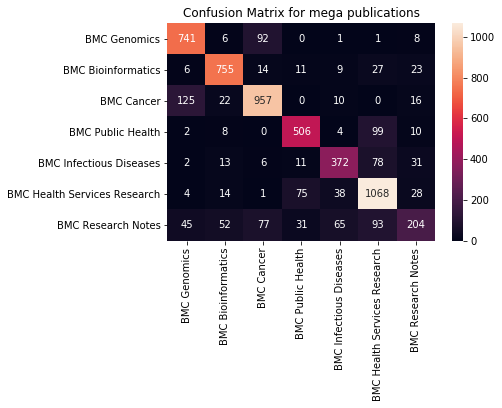

In [158]:
# turn confusion matrix into data frame then run it through seaborn, then print the confusion matrix
import matplotlib.pyplot as plt

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_preds))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=sorted_dict.keys(), yticklabels=sorted_dict.keys())
plt.axes().set_title("Confusion Matrix for mega publications")

# I.D: Conclusions <a class="anchor" id="44-bullet"></a>

After testing the various models and using cross validation and RandomizedSearchCV to find the best hyperparameters and ensure the model's accuracy, we found Logistic Regression to perform the best. We reached an 80% accuracy, which is fair, but not as precise as what we would have liked (we would have liked +95% accuracy). Reaching a greater accuracy would likely have to use more robust models like neural nets or deep learning, which we would hope to do in future analysis. Still, we keep in mind that running a model like a neural net or a deep learning model will not simply raise the accuracy rate, as there could be an irreducible error present in the data set. Another approach to improving accuracy would be further feature engineering that would happen at the TFIDF vectorized matrix level. Perhaps there is a more advanced method other than TFIDF, or a more advanced stop_words method that would be able to remove common words like "case presentation" or "services", words that we found in the unigram/bigram analysis.

Overall, we had expected the unigrams/bigrams to be more distinct than our findings. Upon further reflection, these findings do make sense because they are all within the science domain and have some similarities to each other that would not be easily distinguishable. For example, all abstracts are: 

1. for research papers
2. heavily simplified versions of the paper, which would naturally omit a lot of specific information regarding the topic that could have helped differentiate each publication
3. again, science related

Distinguishing between highly separate topics like politics, economics, and popular culture media would have been much simplier


# Appendix

### trial on journals >= 100 abstracts

In [66]:
trial_100 = classify_me(x_small, y_small, models)
print(trial_100[0])
print("\n Average performance of the models")
print(trial_100[1])

   LinearSVC  RandomForestClassifier  LogisticRegression  \
0   0.525386                0.232005            0.553342   
1   0.567472                0.236715            0.580032   
2   0.575210                0.233699            0.580697   
3   0.599871                0.237294            0.594043   
4   0.590276                0.240519            0.602269   
5   0.586442                0.240026            0.583847   
6   0.574164                0.240506            0.589744   
7   0.567524                0.238855            0.576961   
8   0.574641                0.237940            0.587679   
9   0.549755                0.236542            0.554976   

   KNeighborsClassifier  MultinomialNB  
0              0.296915       0.464010  
1              0.335910       0.477617  
2              0.331827       0.480633  
3              0.340563       0.489155  
4              0.392869       0.494652  
5              0.337334       0.492053  
6              0.338851       0.491399  
7          

### trial on journals with abstract counts >= 1000

didn't run the trial_1000[0], which would have given us the k-folds calculations, because it takes a long time to run (~10 minutes)

In [170]:
x_1000 = x_cleaner(subset_csv_ML_1000)
y_1000 = subset_csv_ML_1000['publicationName']
trial_1000 = classify_me(x_1000, y_1000, models)
print("\n Average performance of the models")
print(trial_1000[1])


 Average performance of the models
LinearSVC                 0.616762
RandomForestClassifier    0.271764
LogisticRegression        0.624691
KNeighborsClassifier      0.476515
MultinomialNB             0.535809
dtype: float64


Subsetting our data set to publications with `abstract counts >= 100` gives us a very low prediction value. At best, `Logistic Regression` here is 60%, not much better than a coin toss. We get the same result with `abstract counts >= 1000`. Only at `abstract counts >= 4000` does the prediction increase to 80%. This rises a couple of questions: Maybe there is a better model? Maybe the abstracts are too similar? There are 67 publications with `abstract counts >= 100` and 34 publications at `abstract counts >= 1000`. Those count levels represent a large quantity of classes, which also likely has a big impact on the classification rate because the nuances between each class are less distinct.

